<h1 style="color:yellow;">Sequential Data - Deep Learning</h1>

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import sys 
sys.path.append(os.path.abspath(".."))

from utils import print_evaluation_metrics, print_memory_usage, clean_database, \
    create_dataloaders, train_and_evaluate_pytorch_model, \
    analyze_correlations, perform_voting_feature_selection, log_metrics, plot_individual_metrics
from preprocess import preprocessing
pd.set_option('display.max_columns', None)

preprocessing_dir = os.path.join('figures','preprocessing')
results_dir = os.path.join('figures', 'results')
evaluation_dir = os.path.join('figures','evaluatoin charts')
db_path = os.path.join('..', 'data', 'datasets', '5G NIDD', 'Combined.csv')

# Data cleaning and splitting

[Preprocessing] Dropping artifact columns: ['Unnamed: 0']
Original shape: (1215890, 51)
Shape after removing duplicates: (1215869, 51)
[Preprocessing] Final feature set (40): ['Dur', 'Mean', 'Sum', 'Min', 'Max', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'SrcGap', 'DstGap', 'Rate', 'SrcRate', 'DstRate', 'State', 'SrcWin', 'DstWin', 'TcpRtt', 'SynAck', 'AckDat']

[Verification] Class distribution (normalized) across splits:
                Original     Train       Val      Test
Attack Type                                           
Benign          0.392901  0.392743  0.393307  0.393759
HTTPFlood       0.115812  0.115800  0.115259  0.116460
ICMPFlood       0.000950  0.000945  0.001003  0.000938
SYNFlood        0.007995  0.007945  0.008389  0.008003
SYNScan         0.016485  0.016527  0.016515

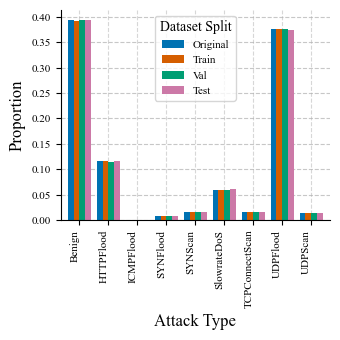

[Memory] Before GC: 1526.39 MB
[Memory] After GC: 1312.75 MB
[Preprocessing] Applying PowerTransformer (Yeo-Johnson) to fix skewness and standardize data...
[Visualization] Plotting top 3 skewed features before transformation: ['DstGap', 'SrcGap', 'DstRate']


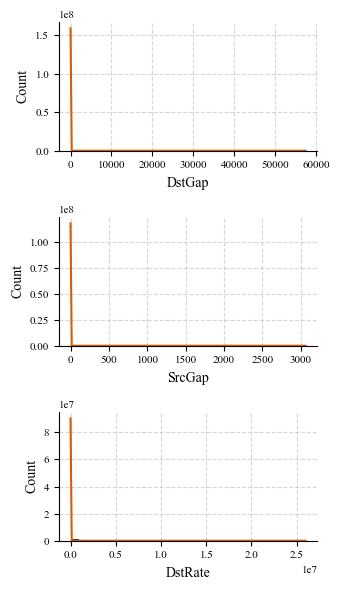

[Visualization] Plotting top 3 skewed features after transformation


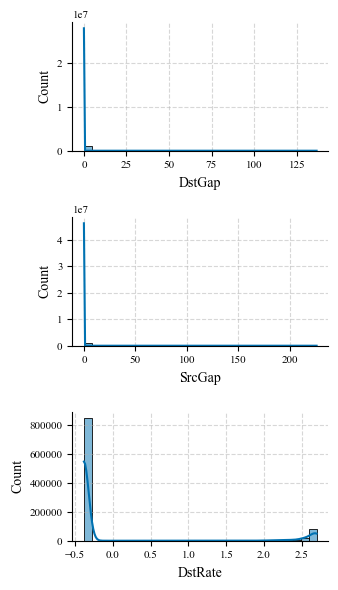

<class 'pandas.core.frame.DataFrame'>
Index: 972695 entries, 285273 to 583254
Data columns (total 40 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dur         972695 non-null  float32
 1   Mean        972695 non-null  float32
 2   Sum         972695 non-null  float32
 3   Min         972695 non-null  float32
 4   Max         972695 non-null  float32
 5   Proto       972695 non-null  float32
 6   sTos        972695 non-null  float32
 7   dTos        972695 non-null  float32
 8   sDSb        972695 non-null  float32
 9   dDSb        972695 non-null  float32
 10  sTtl        972695 non-null  float32
 11  dTtl        972695 non-null  float32
 12  Cause       972695 non-null  float32
 13  TotPkts     972695 non-null  float32
 14  SrcPkts     972695 non-null  float32
 15  DstPkts     972695 non-null  float32
 16  TotBytes    972695 non-null  float32
 17  SrcBytes    972695 non-null  float32
 18  DstBytes    972695 non-null  float32
 19  Of

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test, output_encoder = clean_database(db_path, preprocessing_dir, do_scale=False, fix_skewness=True)
# Force garbage collection to clear the large raw dataframe from memory immediately
gc.collect()
print_memory_usage("Notebook - After clean_database")

# Feature Selection

### Analyze correlation between features

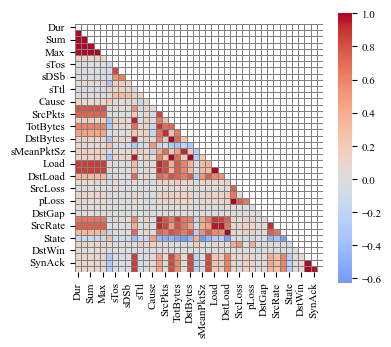


[Analysis] Features with correlation > 0.95:
  - Mean is correlated with ['Dur']
  - Sum is correlated with ['Dur', 'Mean']
  - Min is correlated with ['Dur', 'Mean', 'Sum']
  - Max is correlated with ['Dur', 'Mean', 'Sum', 'Min']
  - DstBytes is correlated with ['dDSb', 'DstPkts']
  - dMeanPktSz is correlated with ['dDSb', 'DstPkts', 'DstBytes']
  - SrcLoad is correlated with ['Load']
  - pLoss is correlated with ['Loss']
  - SrcRate is correlated with ['Load', 'SrcLoad']
  - DstRate is correlated with ['DstLoad']
  - SynAck is correlated with ['TcpRtt']
  - AckDat is correlated with ['TcpRtt', 'SynAck']


In [3]:
high_corr_features = analyze_correlations(X_train, preprocessing_dir, threshold=0.95)

### Drop correlated features

In [4]:
# Use inplace=True to avoid creating a copy of the dataframe in memory
X_train.drop(columns=high_corr_features, inplace=True)
X_val.drop(columns=high_corr_features, inplace=True)
X_test.drop(columns=high_corr_features, inplace=True)
print(f"Dropped {len(high_corr_features)} correlated features.")

gc.collect()
print_memory_usage("Notebook - After Dropping Correlated Features")

Dropped 12 correlated features.
[Memory] Notebook - After Dropping Correlated Features: 1643.41 MB


In [5]:
# Print the number of remaining features
print(f"Remaining features count: {X_train.shape[1]}")

# Print the list of remaining feature names
print("Remaining features list:")
print(X_train.columns.tolist())

Remaining features count: 28
Remaining features list:
['Dur', 'Proto', 'sTos', 'dTos', 'sDSb', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'SrcGap', 'DstGap', 'Rate', 'State', 'SrcWin', 'DstWin', 'TcpRtt']


# Arguments

In [ ]:
version = 'DL'
sampling_method = 'smote'
plot_distributions = True
model_results= []

# Compare the result of all methods


[Comparison] Using full training data (972695 samples) for feature selection.

Comparing Feature Selection Methods

--- Filter Method: pearson ---

[Filter] Starting PEARSON Feature Selection to select top 20 features...
[Filter] Completed in 0.09 seconds.
[Filter] Selected Features: ['Dur', 'Proto', 'sTos', 'dTos', 'dDSb', 'sTtl', 'dTtl', 'Cause', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'SrcLoss', 'State', 'SrcWin', 'TcpRtt']
   -> Validation Accuracy: 0.9791

--- Filter Method: anova ---

[Filter] Starting ANOVA Feature Selection to select top 20 features...
[Filter] Completed in 0.14 seconds.
[Filter] Selected Features: ['Dur', 'Proto', 'dDSb', 'sTtl', 'Cause', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPktSz', 'Load', 'DstLoad', 'Loss', 'DstLoss', 'Rate', 'State', 'SrcWin', 'TcpRtt']
   -> Validation Accuracy: 0.9791

--- Filter Method: chi2 ---

[Filter] Starting CHI2 Feature Selection to select top 20 fe

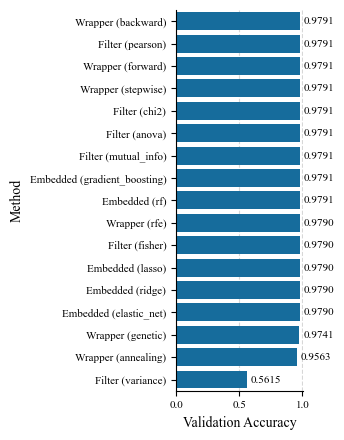


Starting Voting Feature Selection (Top 3 Methods)
Top 3 methods selected for voting:
  - Wrapper (backward) (Accuracy: 0.9791)
  - Filter (pearson) (Accuracy: 0.9791)
  - Wrapper (forward) (Accuracy: 0.9791)
[Voting] Overlap between top 2 methods (Wrapper (backward) & Filter (pearson)): 14/20 features in common.

[Voting] Features selected by majority (2+ votes): ['Proto', 'sTos', 'dTos', 'dDSb', 'sTtl', 'Cause', 'SrcPkts', 'DstPkts', 'SrcBytes', 'Offset', 'DstLoad', 'Loss', 'SrcLoss', 'DstGap', 'Rate', 'SrcWin', 'DstWin', 'TcpRtt', 'dTtl', 'TotBytes', 'State']
[Voting] Total features selected: 21


In [ ]:
selected_features, comparison_results = perform_voting_feature_selection(
    X_train, y_train, X_val, y_val, 
    n_features=20, 
    sample_size=None, 
    top_k=3,
    file_path= preprocessing_dir,
    version=version
)
gc.collect()
print_memory_usage("Notebook - After Feature Selection")

# LDA
# X_train, X_val, X_test = perform_lda_reduction(X_train, y_train, X_val, X_test)

# Autoencoder
# X_train, X_val, X_test = perform_autoencoder_reduction(
#     X_train, X_val, X_test, 
#     encoding_dim=20, 
#     epochs=20, 
#     device=device
# )

## Filter the dataframes to include only selected columns

In [ ]:
# Overwrite your dataframes to keep ONLY the selected columns
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

253

# Preprocessing

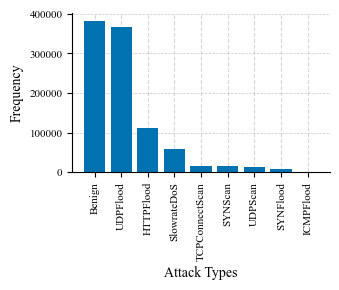

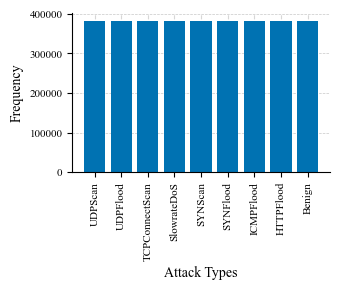

[Memory] Notebook - Ready for Training: 1328.25 MB


In [9]:
X_train_resampled, X_val, X_test, y_resampled, y_val, y_test = preprocessing(X_train, X_val, X_test, y_train, y_val, y_test, output_encoder, preprocessing_dir, version, sampling_method, plot_distributions)
print_memory_usage("Notebook - Ready for Training")

# Deep Learning

In [10]:
import torch
import torch.nn as nn

## Check for device

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Create DataLoaders (Shared for all DL models)

In [12]:
# Note: All models in this setup use the same input shape (N, 1, F)
train_loader, val_loader = create_dataloaders(X_train_resampled, y_resampled, X_val, y_val, batch_size=128)

## Define models

### LSTM

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :] 
        out = self.fc(out)
        return out

### GRU

In [14]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

### CNN

In [15]:

class CNNModel(nn.Module):
    def __init__(self, input_length, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        conv_out_length = input_length - 2
        pool_out_length = conv_out_length // 2
        self.fc_input_dim = 64 * pool_out_length
        self.fc1 = nn.Linear(self.fc_input_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## Initializing and training the models

### Getting input size and number of classes

In [16]:
input_size = X_train_resampled.shape[1]
num_classes = len(np.unique(y_resampled))

### LSTM train and evaluate


--- LSTM Model ---


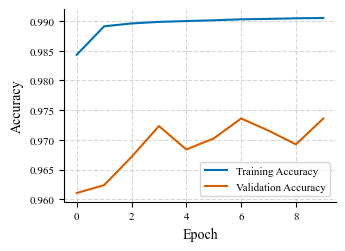

In [17]:
# --- LSTM ---
print("\n--- LSTM Model ---")
lstm_model = LSTMModel(input_size, 64, num_classes)
y_pred_lstm, t_time_lstm, p_time_lstm = train_and_evaluate_pytorch_model(
    lstm_model, train_loader, val_loader, num_epochs=10, device=device, model_name="LSTM"
)

LSTM Evaluation:
Accuracy: 0.97359915
Precision: 0.97397636
Recall: 0.97359915
F1 Score: 0.97360033
Training Time: 299.5383 seconds
Prediction Time: 0.4810 seconds
latency per sample: 0.00000396 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.98247469 0.95190398 0.96694777     47821
     HTTPFlood  0.99764151 0.99607535 0.99685782     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  1.00000000 1.00000000 1.00000000      1020
       SYNScan  0.99800598 0.99701195 0.99750872      2008
   SlowrateDoS  0.99212707 0.99570280 0.99391172      7214
TCPConnectScan  0.99796851 0.99796851 0.99796851      1969
      UDPFlood  0.95151156 0.98226648 0.96664446     45789
       UDPScan  0.99511002 0.99877301 0.99693815      1630

      accuracy                      0.97359915    121587
     macro avg  0.99053771 0.99107801 0.99075302    121587
  weighted avg  0.97397636 0.97359915 0.97360033    121587



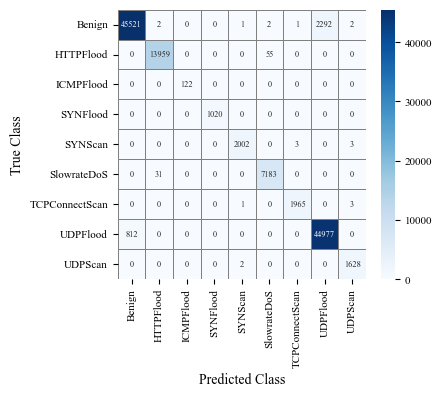

In [18]:
# arguments for evaluation function
results_file_name = 'lstm_results.txt'
cm_title = 'LSTM Confusion Matrix'

print("LSTM Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_lstm, t_time_lstm, p_time_lstm, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'lstm', accuracy, precision, recall, f1, t_time_lstm, p_time_lstm)

### GRU train and evaluate


--- GRU Model ---


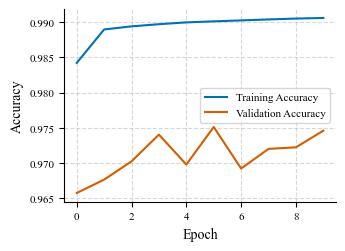

In [19]:
# --- GRU ---
print("\n--- GRU Model ---")
gru_model = GRUModel(input_size, 64, num_classes)
y_pred_gru, t_time_gru, p_time_gru = train_and_evaluate_pytorch_model(
    gru_model, train_loader, val_loader, num_epochs=10, device=device, model_name="GRU"
)

GRU Evaluation:
Accuracy: 0.97458610
Precision: 0.97521481
Recall: 0.97458610
F1 Score: 0.97458521
Training Time: 254.1994 seconds
Prediction Time: 0.4332 seconds
latency per sample: 0.00000356 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.98864775 0.94880910 0.96831884     47821
     HTTPFlood  0.99735204 0.99443414 0.99589095     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  1.00000000 1.00000000 1.00000000      1020
       SYNScan  0.99750872 0.99701195 0.99726027      2008
   SlowrateDoS  0.98898527 0.99570280 0.99233267      7214
TCPConnectScan  0.99746322 0.99847638 0.99796954      1969
      UDPFlood  0.94891521 0.98862172 0.96836161     45789
       UDPScan  0.99693627 0.99815951 0.99754752      1630

      accuracy                      0.97458610    121587
     macro avg  0.99064539 0.99124618 0.99085349    121587
  weighted avg  0.97521481 0.97458610 0.97458521    121587



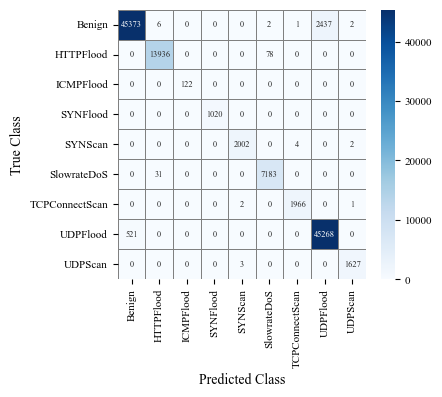

In [20]:
# arguments for evaluation function
results_file_name = 'gru_results.txt'
cm_title = 'GRU Confusion Matrix'

print("GRU Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_gru, t_time_gru, p_time_gru, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'gru', accuracy, precision, recall, f1, t_time_gru, p_time_gru)

### CNN train and evaluate


--- CNN Model ---


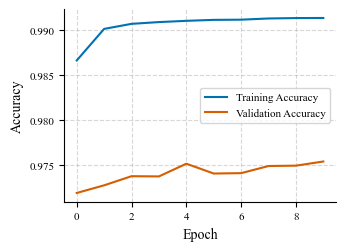

In [21]:
# --- CNN ---
print("\n--- CNN Model ---")
cnn_model = CNNModel(input_size, num_classes)
y_pred_cnn, t_time_cnn, p_time_cnn = train_and_evaluate_pytorch_model(
    cnn_model, train_loader, val_loader, num_epochs=10, device=device, model_name="CNN"
)

Logistic Regression Evaluation:
Accuracy: 0.97543323
Precision: 0.97641788
Recall: 0.97543323
F1 Score: 0.97542719
Training Time: 2011.9383 seconds
Prediction Time: 1.8350 seconds
latency per sample: 0.00001509 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.99493347 0.94448046 0.96905071     47821
     HTTPFlood  0.99728455 0.99586128 0.99657241     14014
     ICMPFlood  0.98387097 1.00000000 0.99186992       122
      SYNFlood  1.00000000 1.00000000 1.00000000      1020
       SYNScan  0.99800499 0.99651394 0.99725891      2008
   SlowrateDoS  0.99157808 0.99556418 0.99356713      7214
TCPConnectScan  0.99493927 0.99847638 0.99670469      1969
      UDPFlood  0.94528705 0.99499880 0.96950610     45789
       UDPScan  0.99693627 0.99815951 0.99754752      1630

      accuracy                      0.97543323    121587
     macro avg  0.98920385 0.99156162 0.99023082    121587
  weighted avg  0.97641788 0.97543323 0.97542719   

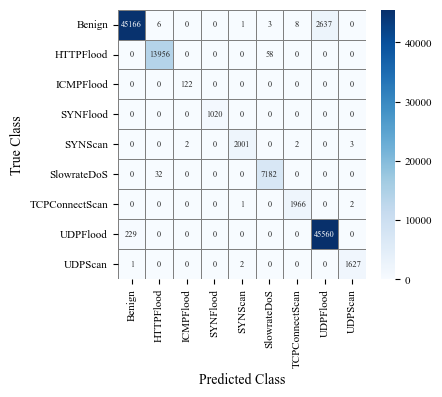

In [22]:
# arguments for evaluation function
results_file_name = 'cnn_results.txt'
cm_title = 'CNN Confusion Matrix'

print("Logistic Regression Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val, y_pred_cnn, t_time_cnn, p_time_cnn, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'cnn', accuracy, precision, recall, f1, t_time_cnn, p_time_cnn)

# Bar charts

Saved DL_comparison_accuracy.pdf


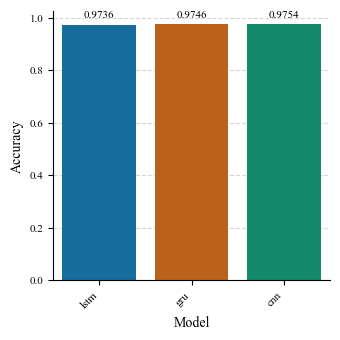

Saved DL_comparison_precision.pdf


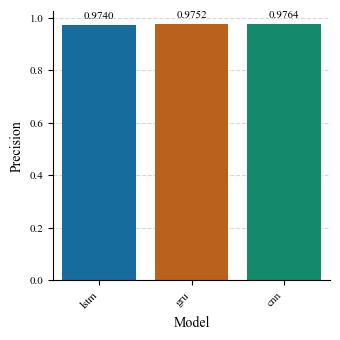

Saved DL_comparison_recall.pdf


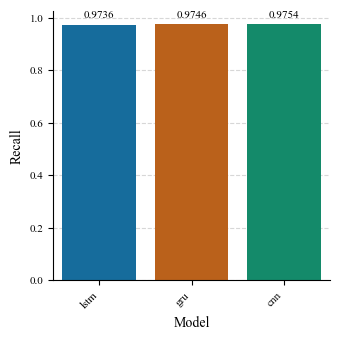

Saved DL_comparison_f1-score.pdf


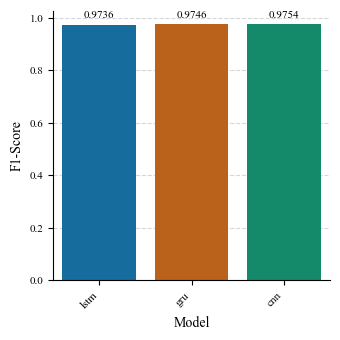

Saved DL_comparison_training_time_s.pdf


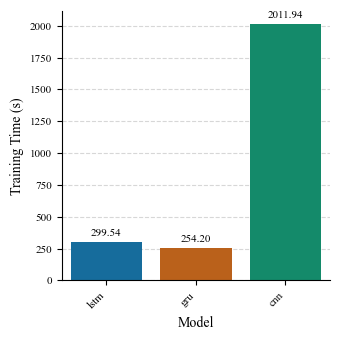

Saved DL_comparison_prediction_time_s.pdf


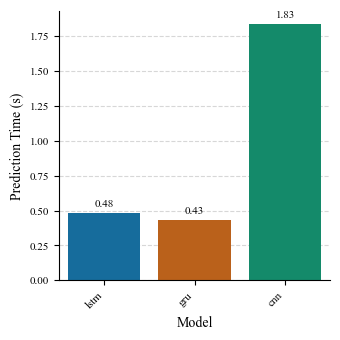

In [23]:
plot_individual_metrics(model_results, evaluation_dir, version)